# KAN AutoEncoders

In [ ]:
# @title setup and imports

import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import math


import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.mnist import MNIST

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# @title Efficient KAN implementation

# reference :

class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        # x = x.view(-1, 28 * 28)
        x = torch.flatten(x, start_dim=1)
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        # x = x.reshape(-1, 1, 28, 28)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [ ]:
# @title MLP Architectures

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fe = nn.Sequential(nn.Linear(784, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 64),
                                nn.ReLU(inplace=True))
        self.fc = nn.Linear(64, 10)

    def last_hidden_layer(self, x):
        x = torch.flatten(x, start_dim=1) / 255.
        return self.fe(x)

    def forward(self, x):
        out = self.last_hidden_layer(x)
        out = self.fc(out)
        return out


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # The Encoder Network
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(28 * 28, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 16),)
        # The Decoder Network
        self.decoder = nn.Sequential(nn.Linear(16, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 28 * 28),
                                     nn.Unflatten(1, (1, 28, 28)),
                                     nn.Sigmoid())

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out


In [ ]:
# @title helper functions

def classifier_train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def classifier_test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_acc += (logits.argmax(dim=1) == labels).sum().item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader.dataset)
    return test_loss, test_acc


def train_classifier(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    optimizer = Adam(model.parameters())
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = classifier_train_step(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        test_loss, test_acc = classifier_test_step(model, test_dataloader, loss_fn, device)
        history['test_loss'].append(test_loss), history['test_acc'].append(test_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Test Accuracy {100 * test_acc:.2f}% ')
    return history


def add_noise(x, noise_factor=0.2):
    return x + torch.randn_like(x) * noise_factor


def autoencoder_train_step(model, dataloader, loss_fn, optimizer, denoising, device):
    model.train()
    train_loss = 0.
    for images, _ in dataloader:
        images = images.to(device)
        images = torch.flatten(images, start_dim=1)
        if denoising: # Add noise to the images
            noisy_images = add_noise(images, noise_factor=0.2)
            recons = model(noisy_images)
        else:
            recons = model(images)
        # print(images.shape, recons.shape)
        loss = loss_fn(recons, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss


def autoencoder_test_step(model, dataloader, loss_fn, denoising, device):
    model.eval()
    test_loss = 0.
    with torch.inference_mode():
        for images, _ in dataloader:
            images = torch.flatten(images, start_dim=1)
            images = images.to(device)
            if denoising: # Add noise to the images
                noisy_images = add_noise(images, noise_factor=0.2)
                recons = model(noisy_images)
            else:
                recons = model(images)
            loss = loss_fn(recons, images)
            test_loss += loss.item()
        test_loss /= len(dataloader)
    return test_loss


def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


def train_vae(model, optimizer, data_loader, n_epochs=50):
    model.train()
    losses = list()
    for _ in (pbar := trange(n_epochs)):
        overall_loss = 0
        for x, _ in data_loader:
            x = x.view(-1, 28*28).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()

            optimizer.step()

        losses.append(overall_loss/len(data_loader.dataset))

        pbar.set_description(f'Loss = {losses[-1]:.2f}')


    return losses


def train_autoencoder(model, train_dataloader, test_dataloader, n_epochs, denoising=False, device=device):
    history = {'train_loss': [], 'test_loss': []}
    optimizer = Adam(model.parameters())
    loss_fn = nn.MSELoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss = autoencoder_train_step(model, train_dataloader, loss_fn, optimizer, denoising, device)
        history['train_loss'].append(train_loss)
        test_loss = autoencoder_test_step(model, test_dataloader, loss_fn, denoising, device)
        history['test_loss'].append(test_loss)
        pbar.set_description(f'Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f}')
    return history


In [ ]:
# @title plotting functions

def plot_history(history):
    if 'train_acc' in history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['train_loss'], label='train')
        ax1.plot(history['test_loss'], label='test')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(history['train_acc'], label='train')
        ax2.plot(history['test_acc'], label='test')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['test_loss'], label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()


def plot_conf_mat(model, dataloader, device=device):
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def visualize(embedded, labels, title=''):
    fig, ax = plt.subplots(figsize=(12,8))

    # get discrete colormap
    cmap = plt.get_cmap('jet', 10) # virdis

    # plot scatter points
    scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap=cmap)

    # add colorbar
    cbar = plt.colorbar(scatter)

    # set ticks locations
    cbar.set_ticks((np.arange(10) + 0.5) * (10 - 1) / 10)

    # set tick labels
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title(title)
    plt.show()


def plot_last_hidden_layer(model, dataloader, method='PCA'):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.last_hidden_layer(imgs.to(device))
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using t-SNE'

    visualize(embedded, labels, title)


def plot_autoencoder(model, dataloader, method='PCA'):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.encoder(imgs.to(device))
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if encoded_data.shape[1] == 2:
        embedded = encoded_data
        title = 'Latent Space'
    elif method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using t-SNE'

    visualize(embedded, labels, title)



def plot_reconstruction(model, dataset, denoising=False):
    # Choose 10 random samples
    random_indices = np.random.choice(len(dataset), size=10, replace=False)

    # Get images and labels for the chosen samples
    images = [dataset[i][0] for i in random_indices]
    labels = [dataset[i][1] for i in random_indices]

    if denoising:
        noisy_images = [add_noise(image) for image in images]

    # Reconstruct the images using the autoencoder
    with torch.no_grad():
        if denoising:
            reconstructed_images = [model(noisy_image.unsqueeze(0).to(device)).squeeze().cpu() for noisy_image in noisy_images]
        else:
            reconstructed_images = [model(image.unsqueeze(0).to(device)).squeeze().cpu() for image in images]

    if denoising:
        # Display the original and reconstructed images
        fig, axes = plt.convolutions(3, 10, figsize=(15, 5))

        # First row: Original images
        for i, image in enumerate(images):
            axes[0, i].imshow(image.squeeze().numpy(), cmap='gray')
            axes[0, i].set_title(f"Original {labels[i]}")
            axes[0, i].axis('off')

        # Second row: Noisy images
        for i, image in enumerate(noisy_images):
            axes[1, i].imshow(image.squeeze().numpy(), cmap='gray')
            axes[1, i].set_title(f"Noisy {labels[i]}")
            axes[1, i].axis('off')

        # Third row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            axes[2, i].imshow(image.squeeze().numpy().reshape(28, 28), cmap='gray')
            axes[2, i].set_title(f"Reconstructed")
            axes[2, i].axis('off')

    else:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))

        # First row: Original images
        for i, image in enumerate(images):
            axes[0, i].imshow(image.squeeze().numpy(), cmap='gray')
            axes[0, i].set_title(f"Label: {labels[i]}")
            axes[0, i].axis('off')

        # Second row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            axes[1, i].imshow(image.detach().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# @title MNIST dataset

batch_size = 256

trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2018754.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346419.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 762975.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8651466.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# KAN vs. MLP on Classification

## MLP

Training Accuracy 95.03% | Test Accuracy 94.84% : 100%|██████████| 30/30 [04:21<00:00,  8.73s/it]


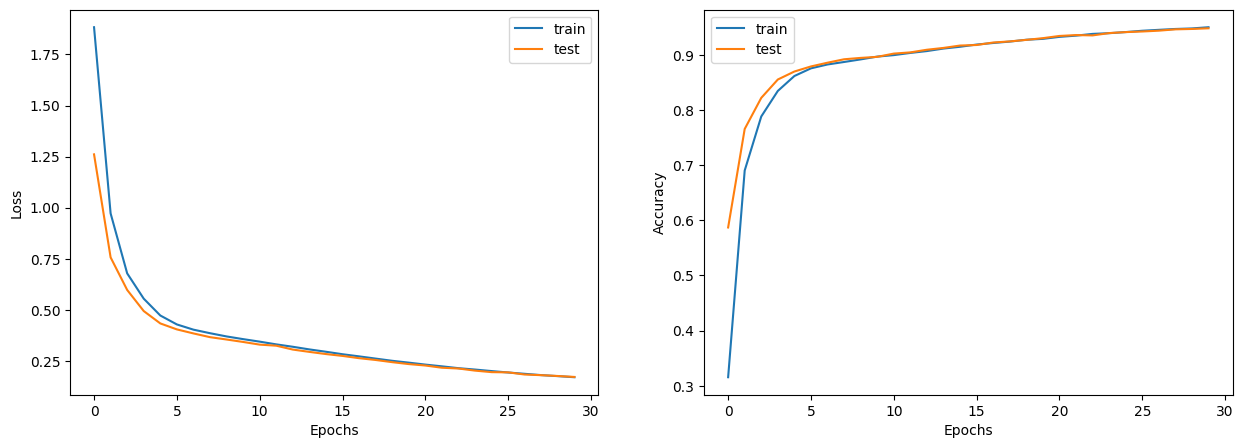

In [ ]:
net = Network().to(device)

results = train_classifier(net, trainloader, testloader, n_epochs=30)
plot_history(results)

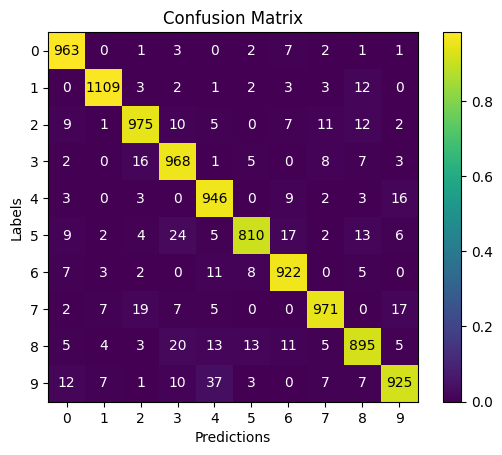

In [ ]:
plot_conf_mat(net, testloader)

## KAN

Training Accuracy 99.84% | Test Accuracy 97.10% : 100%|██████████| 30/30 [05:43<00:00, 11.45s/it]


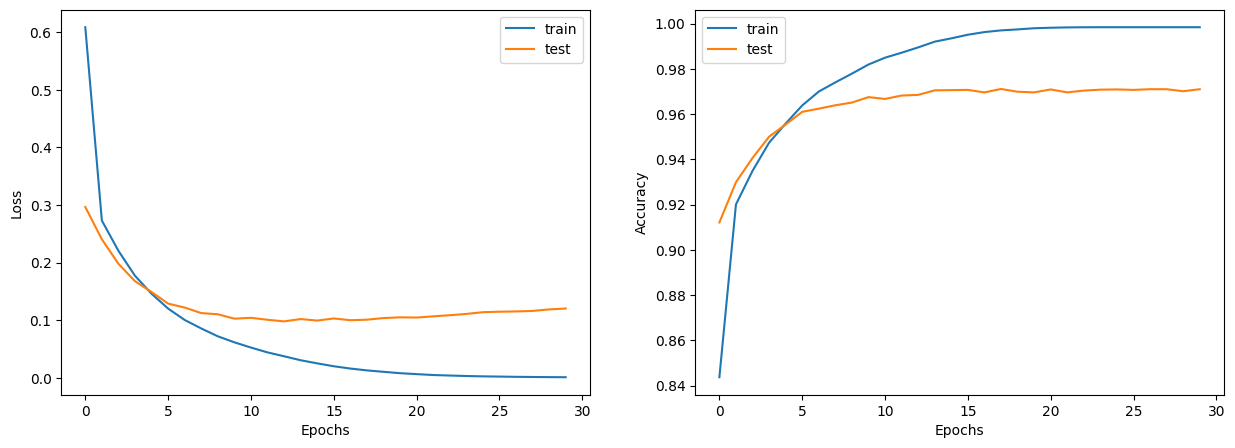

In [ ]:
model = KAN([28 * 28, 64, 10]).to(device)

res = train_classifier(model, trainloader, testloader, n_epochs=30)
plot_history(res)

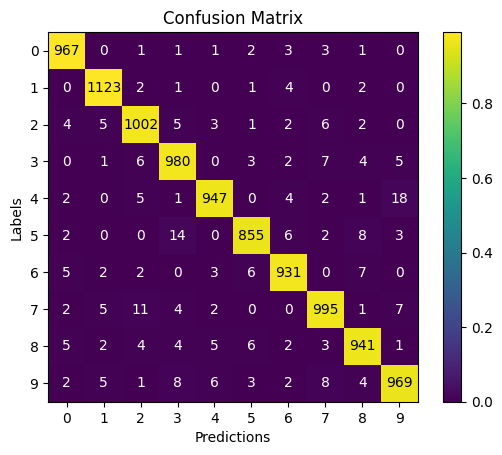

In [ ]:
plot_conf_mat(model, testloader)

# KAN vs. MLP on Dimensionality Reduction

## MLP

Training Loss 0.011 | Test Loss 0.011 : 100%|██████████| 30/30 [04:08<00:00,  8.27s/it]


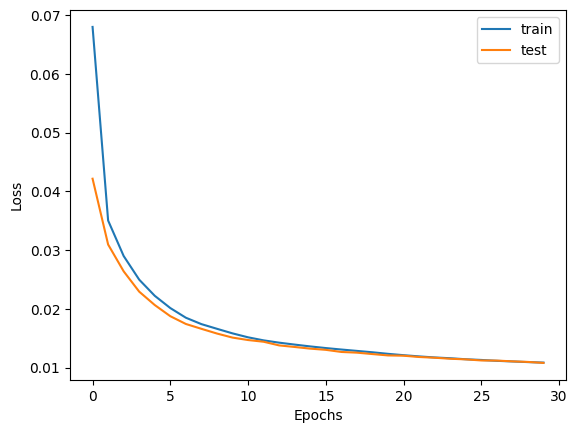

In [ ]:
autoencoder = AutoEncoder().to(device)

res = train_autoencoder(autoencoder, trainloader, testloader, n_epochs=30)
plot_history(res)

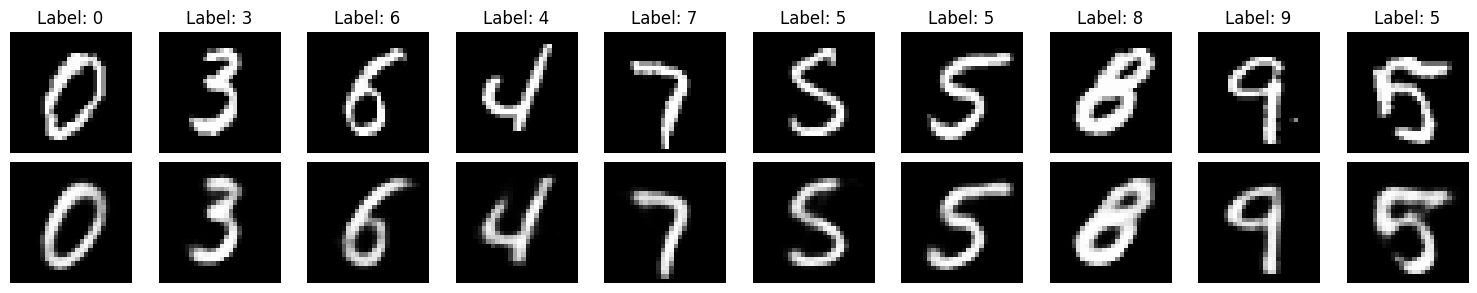

In [ ]:
plot_reconstruction(autoencoder, testset)

### Latent Variable Space

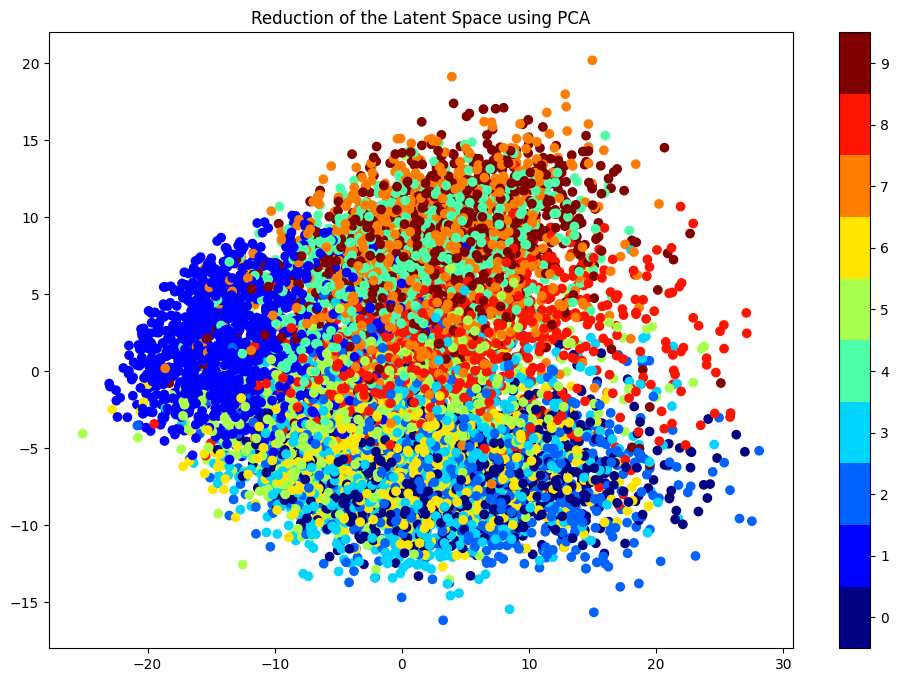

In [ ]:
plot_autoencoder(autoencoder, testloader, method='PCA')

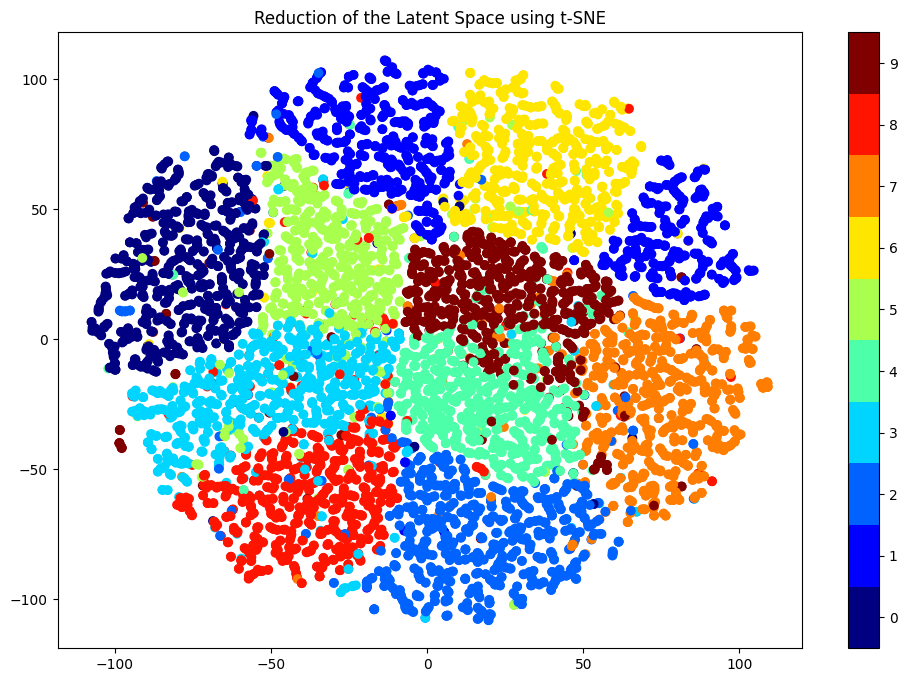

In [ ]:
plot_autoencoder(autoencoder, testloader, method='t-SNE')

### Denoising

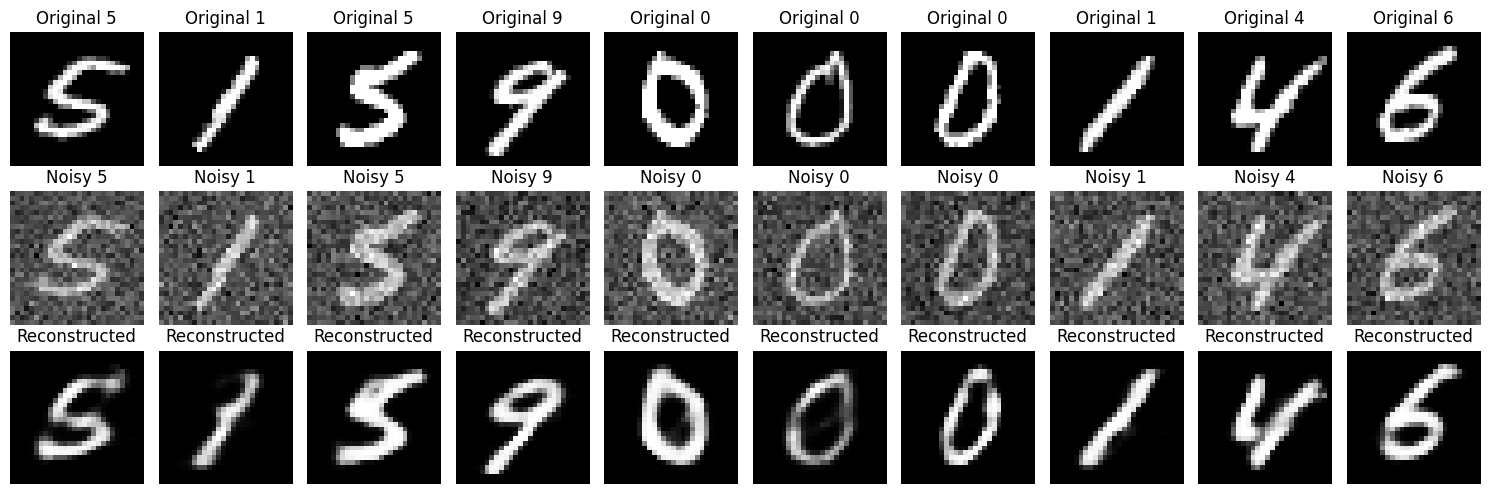

In [ ]:
plot_reconstruction(autoencoder, testset, denoising=True)

## KAN

In [ ]:
class KANcoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = KAN([28 * 28, 256, 10])
        self.decoder = nn.Sequential(KAN([10, 256, 28 * 28]),
                                     nn.Sigmoid())

    def forward(self, x):
        return self.decoder(self.encoder(x))

Training Loss 0.013 | Test Loss 0.014: 100%|██████████| 15/15 [02:57<00:00, 11.82s/it]


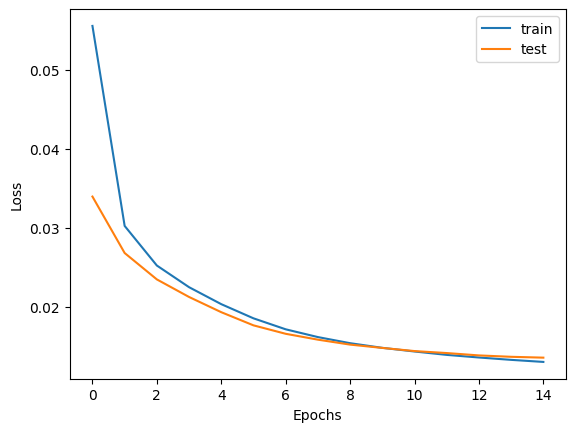

In [ ]:
model = KANcoder().to(device)

res = train_autoencoder(model, trainloader, testloader, n_epochs=15)
plot_history(res)

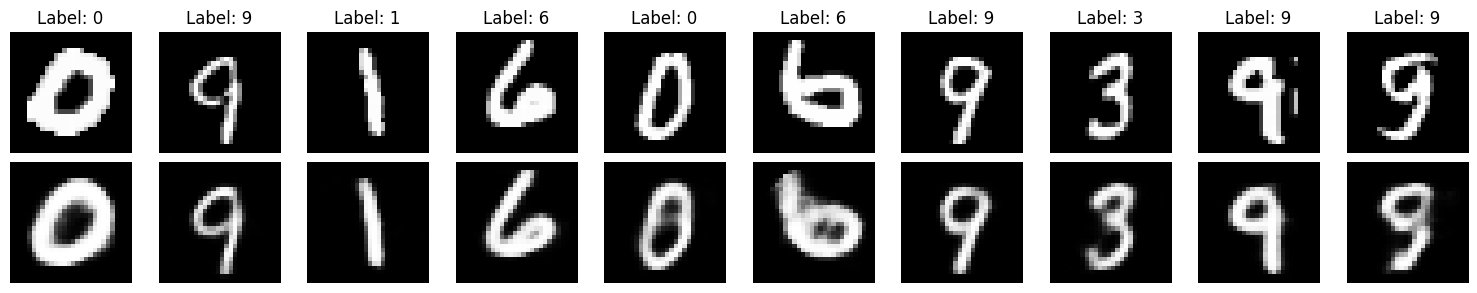

In [ ]:
plot_reconstruction(model, testset)

### Latent Variable Space

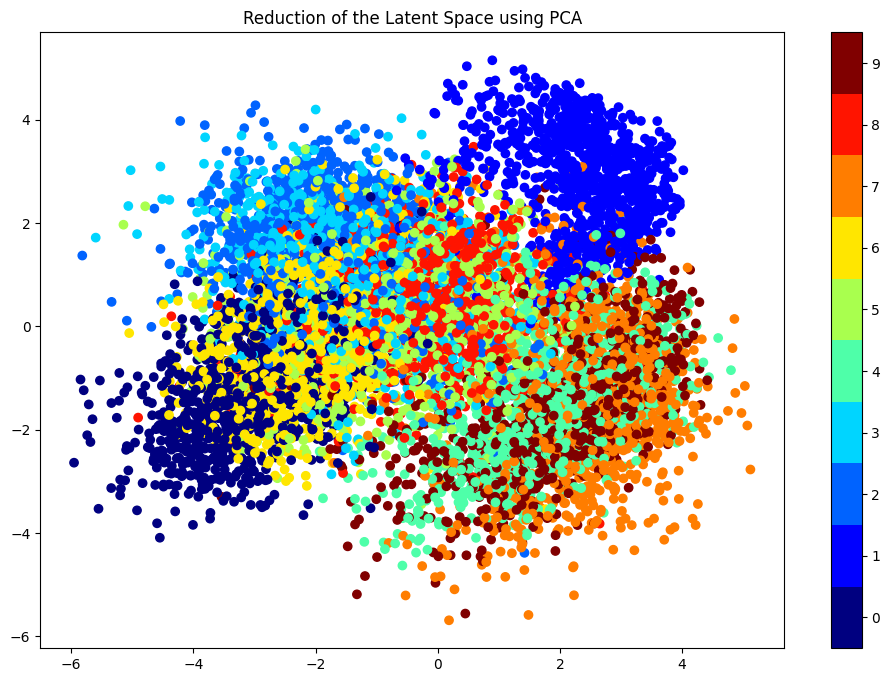

In [ ]:
plot_autoencoder(model, testloader, 'PCA')

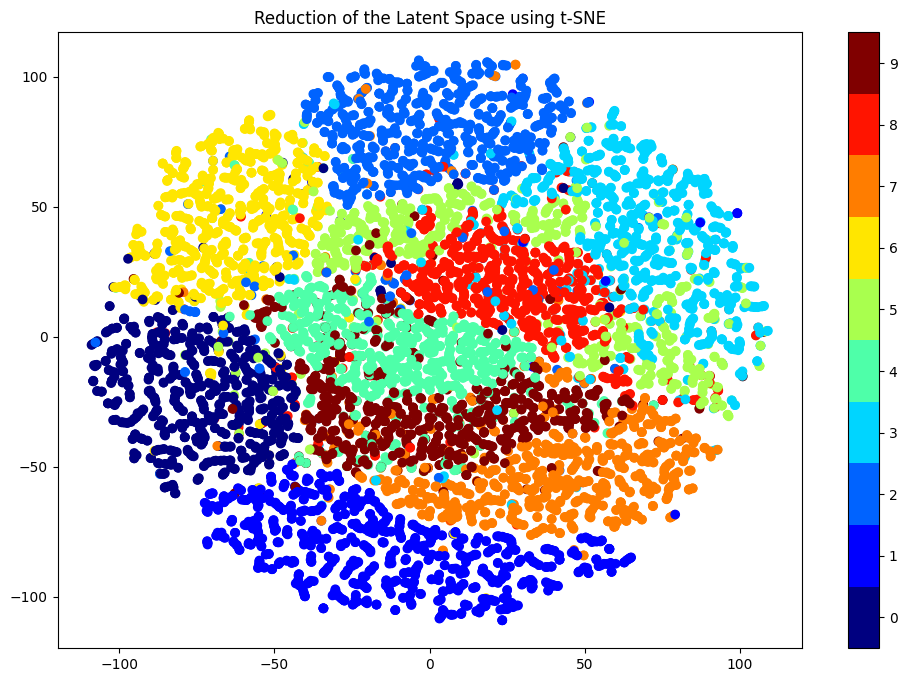

In [ ]:
plot_autoencoder(model, testloader, method='t-SNE')

### Denoising

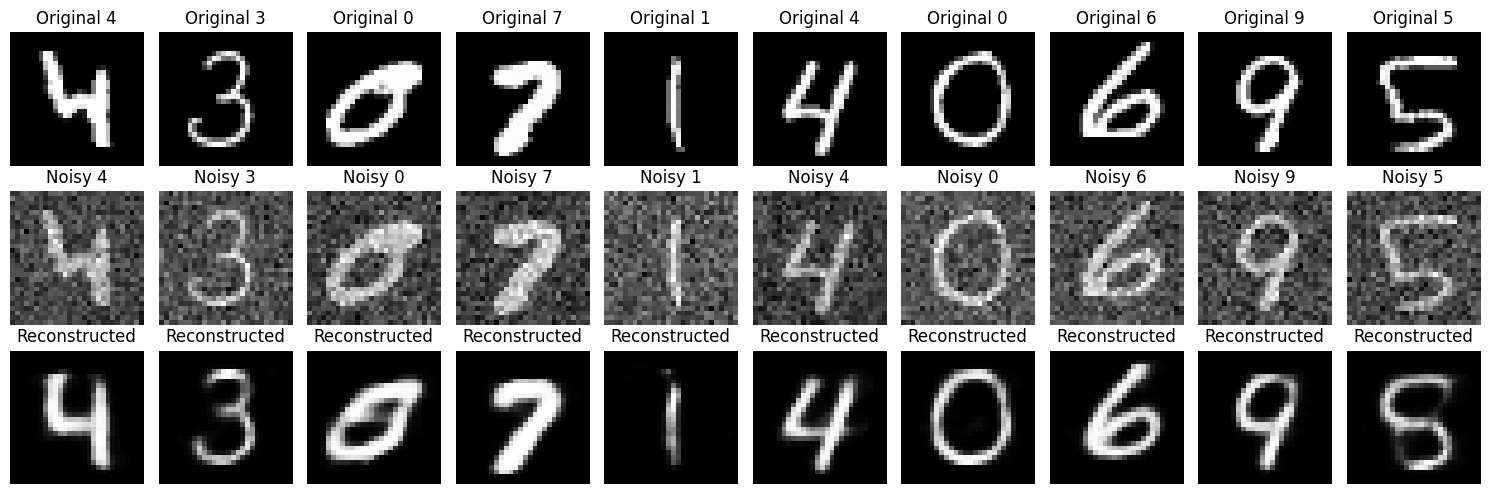

In [ ]:
plot_reconstruction(model, testset, denoising=True)

# VAE

In [ ]:
class VAE_KAN(nn.Module):
    def __init__(self,input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = KAN([input_dim, hidden_dim , hidden_dim])

        self.fc_mu = KAN([hidden_dim, latent_dim])
        self.fc_logvar = KAN([hidden_dim, latent_dim])

        self.decoder = nn.Sequential(KAN([latent_dim, hidden_dim, input_dim]),
                                     nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [ ]:
# Training function
def train(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device).view(-1, 784)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    return avg_train_loss

# Validation function
def validate(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device).view(-1, 784)
            recon_x, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss

# Example training loop with validation
def train_vae_with_validation(model, train_loader, val_loader, optimizer, device, epochs=10):
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

In [ ]:
input_dim = 28 * 28  # For MNIST images
hidden_dim = 400
latent_dim = 20

In [ ]:
vae_kan = VAE_KAN(input_dim, hidden_dim, latent_dim)
vae_kan.to(device)
optimizer = torch.optim.Adam(vae_kan.parameters(), lr=1e-3)

In [ ]:
train_vae_with_validation(vae_kan, trainloader, testloader, optimizer, device, epochs=10)

Epoch [1/10], Train Loss: 208.0452, Validation Loss: 161.8871
Epoch [2/10], Train Loss: 146.2198, Validation Loss: 133.1912
Epoch [3/10], Train Loss: 126.3525, Validation Loss: 119.7126
Epoch [4/10], Train Loss: 116.7344, Validation Loss: 112.7090
Epoch [5/10], Train Loss: 111.4608, Validation Loss: 109.0163
Epoch [6/10], Train Loss: 108.2479, Validation Loss: 106.6877
Epoch [7/10], Train Loss: 106.0638, Validation Loss: 105.1150
Epoch [8/10], Train Loss: 104.5368, Validation Loss: 103.8743
Epoch [9/10], Train Loss: 103.4112, Validation Loss: 103.1358
Epoch [10/10], Train Loss: 102.4579, Validation Loss: 102.2174


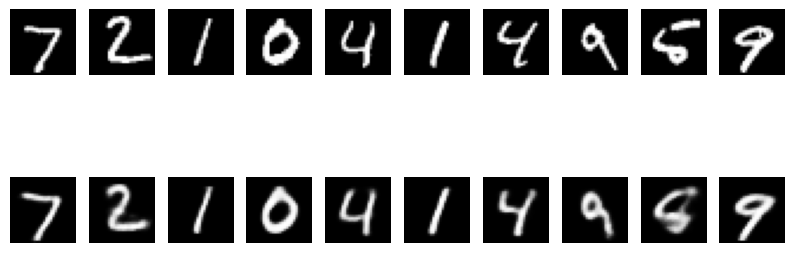

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device).view(-1, 784)
            recon_x, _, _ = model(x)

            # Display original and reconstructed images
            original = x.view(-1, 1, 28, 28).cpu()
            reconstructed = recon_x.view(-1, 1, 28, 28).cpu()

            # Plot images
            plt.figure(figsize=(10, 4))
            for i in range(10):  # Display first 10 images
                plt.subplot(2, 10, i + 1)
                plt.imshow(original[i][0], cmap='gray')
                plt.axis('off')
                plt.subplot(2, 10, i + 11)
                plt.imshow(reconstructed[i][0], cmap='gray')
                plt.axis('off')
            plt.show()
            break  # Only visualize one batch

visualize_reconstructions(vae_kan, testloader, device)

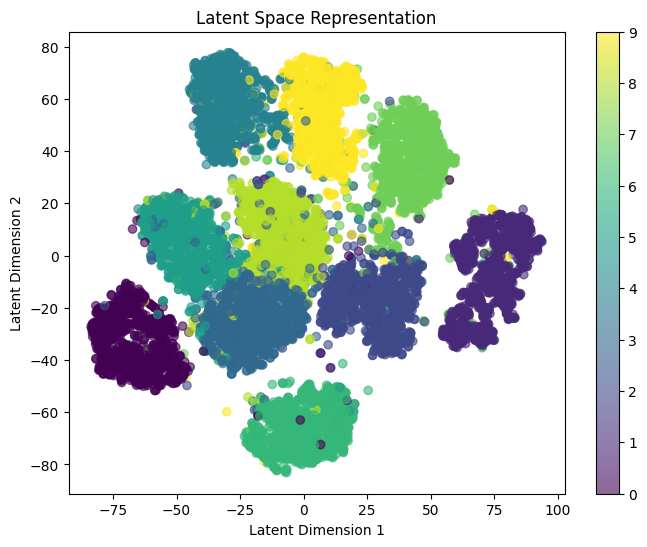

In [ ]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, device):
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for x, labels in data_loader:
            x = x.to(device).view(-1, 784)
            mu, _ = model.fc_mu(model.encoder(x)), model.fc_logvar(model.encoder(x))
            all_latents.append(mu.cpu())
            all_labels.append(labels)

    latents = torch.cat(all_latents).numpy()
    labels = torch.cat(all_labels).numpy()

    # Use t-SNE to reduce dimensions for visualization
    tsne = TSNE(n_components=2)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title("Latent Space Representation")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

visualize_latent_space(vae_kan, testloader, device)